# Ансамбли

In [ ]:
# !pip install mlxtend

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import cm
from matplotlib.colors import ListedColormap
from mlxtend.plotting import plot_decision_regions
from sklearn.datasets import load_digits, load_iris, make_moons
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

%matplotlib inline

In [ ]:
plt.rcParams['figure.figsize'] = (14, 6)

## Деревья vs линейные модели

**Задача.** Пусть решается задача регрессии на одномерной выборке $X = \{ (x_i, y_i)\}_{i=1}^l,$ при этом истинная зависимость целевой переменной является линейной: $y(x) = ax + \varepsilon, \, \varepsilon \sim p(\varepsilon) = \mathcal{N} (0, \sigma^2).$ Допустим, не зная этого, вы обучили на выборке линейную регрессию и решающее дерево с функционалом MSE, и вам известно, что модели не переобучились. После этого вы получили новые данные и построили на них прогнозы обеих моделей, и оказалось, что для решающего дерева значение функционала ошибки на новых данных оказалось радикально выше, чем для линейной регрессии. Чем это может быть вызвано?

**Решение.**
Поскольку истинная зависимость в данных является линейной, логично предположить, что линейная модель покажет лучшие результаты на подобной выборке. Опишем формально ситуацию, в которой у решающего дерева могут возникнуть серьезные проблемы с восстановлением истинной зависимости.

Допустим, обучающая выборка была получена из отрезка $[0; 10],$ обучим соответствующие модели и построим прогнозы для этого отрезка:

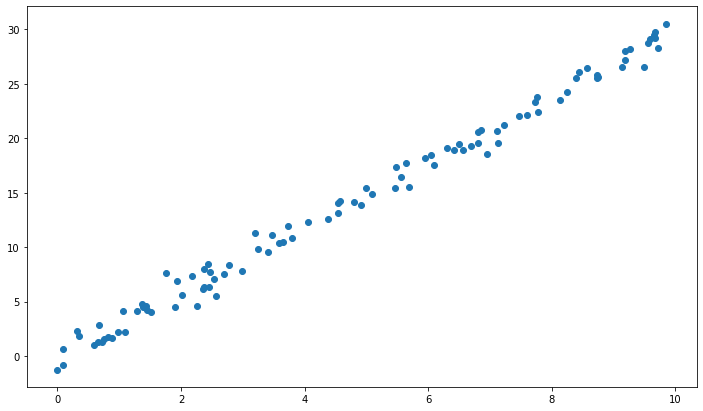

In [ ]:
set_size = 100
lin_coef = 3
sigma = 1

np.random.seed(13)

X_train = (np.random.rand(set_size) * 10).reshape(-1, 1)
Y_train = X_train * 3 + sigma * np.random.randn(set_size).reshape(-1, 1)
plt.figure(figsize=(12, 7))
plt.scatter(X_train, Y_train)
plt.show()

In [ ]:
lr = LinearRegression()
lr.fit(X_train, Y_train)
tree = DecisionTreeRegressor()
tree.fit(X_train, Y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

LR train MSE =  0.7264320462358224
DT train MSE =  0.0


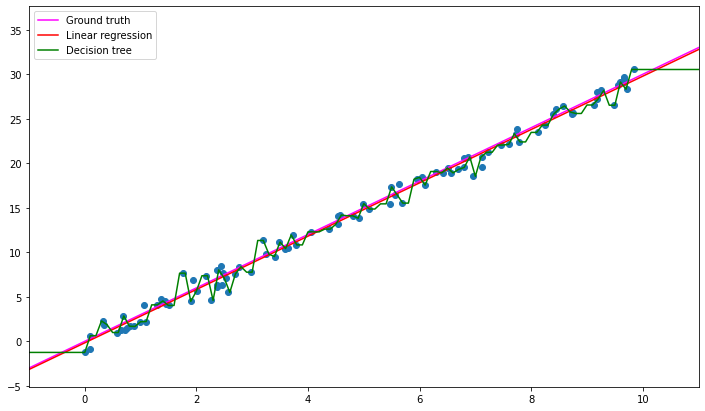

In [ ]:
grid = np.arange(-1, 12, 0.1).reshape(-1, 1)

plt.figure(figsize=(12, 7))
plt.scatter(X_train, Y_train)
plt.plot(grid, lin_coef * grid, 'magenta')
plt.plot(grid, lr.predict(grid), 'red',)
plt.plot(grid, tree.predict(grid), 'green')
plt.xlim([-1, 11])
plt.legend(['Ground truth', 'Linear regression', 'Decision tree'], loc=0)
print ('LR train MSE = ', mean_squared_error(Y_train, lr.predict(X_train)))
print ('DT train MSE = ', mean_squared_error(Y_train, tree.predict(X_train)))

Предположим, что новые данные были получены из другой области пространства ответов, например, из отрезка $[20; 30].$ В этом случае предсказания линейной регрессии окажутся гораздо ближе к правде, что отразится и на значении функционала ошибки:

LR test MSE =  1.0221249155273031
DT test MSE =  2006.0600591143823


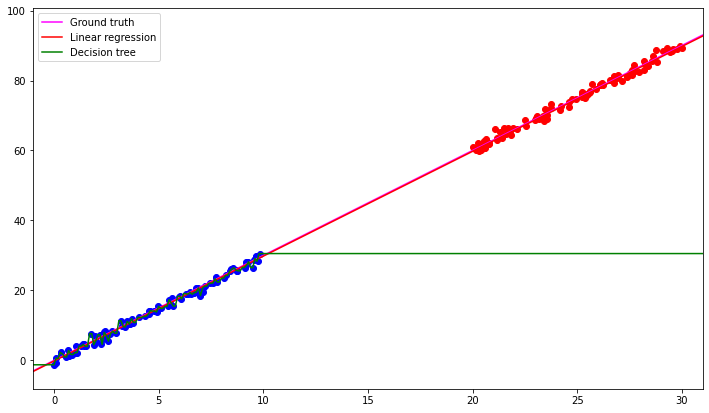

In [ ]:
grid = np.arange(-1, 32, 0.1).reshape(-1, 1)

X_test = (20 + np.random.rand(set_size) * 10).reshape(-1, 1)
Y_test = X_test * 3 + sigma * np.random.randn(set_size).reshape(-1, 1)
plt.figure(figsize=(12, 7))
plt.scatter(X_train, Y_train, c='blue')
plt.scatter(X_test, Y_test, c='red')

plt.plot(grid, lin_coef * grid, 'magenta')
plt.plot(grid, lr.predict(grid), 'red',)
plt.plot(grid, tree.predict(grid), 'green')
plt.xlim([-1, 31])
plt.legend(['Ground truth', 'Linear regression', 'Decision tree'], loc=0)
print ('LR test MSE = ', mean_squared_error(Y_test, lr.predict(X_test)))
print ('DT test MSE = ', mean_squared_error(Y_test, tree.predict(X_test)))

**Вывод**: решающие деревья (а потому и композиции над ними) непригодны для экстраполяции функций.

## Почему ансамбли важны?
Давайте посмотрим, как уменьшается разброс предсказания с ростом числа элементов. Проведем эксперимент с подбрасыванием неправильной монетки.

In [ ]:
heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

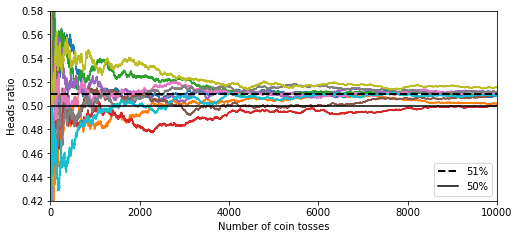

In [ ]:
plt.figure(figsize=(8,3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
plt.show()

Что мы наблюдаем?

В первую очередь давайте попробуем объединить абсолютно разные алгоритмы. Сделаем это с помощью класса `VotingClassifier`.

In [ ]:
??VotingClassifier

In [ ]:
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

In [ ]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=42,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                               

In [ ]:
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


Теперь попробуем голосовать, взвешивая вероятности.

In [ ]:
log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=42,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                               

In [ ]:
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


Несмотря на то, что у исходных моделей качество осталось таким же, ансамбль стал сильнее, так как получил больше информации. нам нужно быть здесь аккуратными

## Bagging ensembles

In [ ]:
??BaggingClassifier

In [ ]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [ ]:
print(accuracy_score(y_test, y_pred))

0.912


In [ ]:
len(y_test)

125

In [ ]:
bag_clf.oob_score_

0.8986666666666666

In [ ]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())
/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


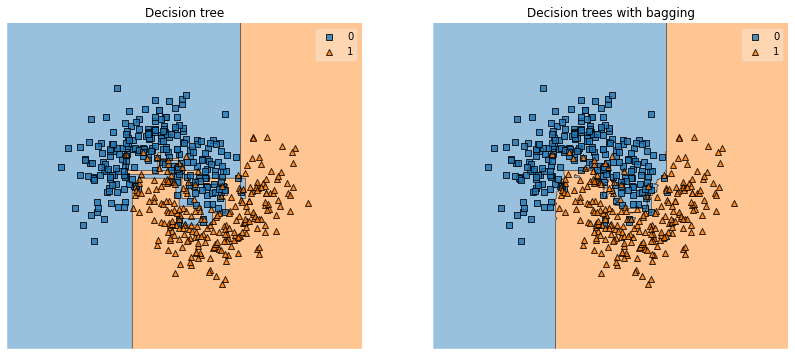

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2)

plot_decision_regions(X, y, tree_clf, ax=ax[0])
ax[0].axis('off')
ax[0].set_title('Decision tree')

plot_decision_regions(X, y, bag_clf, ax=ax[1])
ax[1].axis('off')
ax[1].set_title('Decision trees with bagging')

plt.show()

Какой вывод из картинок можно сделать?

## Random Forests

In [ ]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16, random_state=42),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1, random_state=42)

In [ ]:
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [ ]:
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred_rf)

0.912

In [ ]:
np.sum(y_pred == y_pred_rf) / len(y_pred)  # предсказания случайного леса и беггинга почти не отличаются

0.976

/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())
/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


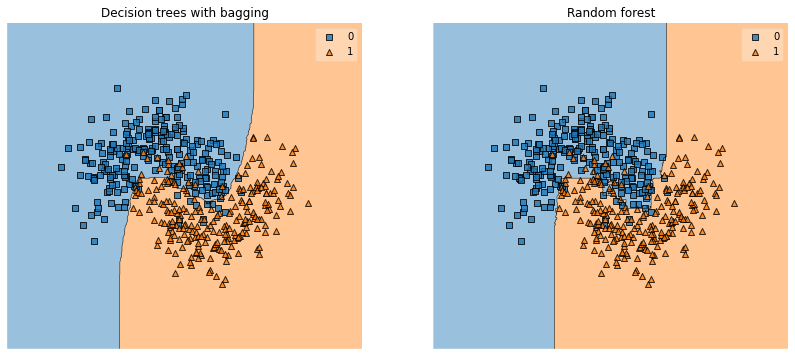

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2)

plot_decision_regions(X, y, bag_clf, ax=ax[0])
ax[0].axis('off')
ax[0].set_title('Decision trees with bagging')

plot_decision_regions(X, y, rnd_clf, ax=ax[1])
ax[1].axis('off')
ax[1].set_title('Random forest')

plt.show()

Для случайного леса можно вычислить важности признаков.

In [ ]:
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


Посмотрим, как выглядят объединенные предсказания нескольких деревьев.

In [ ]:
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=14)
    plt.ylabel(r"$x_2$", fontsize=14, rotation=0)

In [ ]:
plt.figure(figsize=(6, 4))

for i in range(15):
    tree_clf = DecisionTreeClassifier(max_leaf_nodes=16, random_state=42 + i)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
    tree_clf.fit(X[indices_with_replacement], y[indices_with_replacement])
    plot_decision_boundary(tree_clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.02, contour=False)

plt.show()

## Out-of-Bag evaluation

Важным сигналом качества ансамблей может быть out-of-bag score. Это средняя ошибка, которая произошла на примере $x_i$ на тех деревьях, которые не видели этот пример.

Большой плюс в том, что этот score можно получить дешево во время обучения.

In [ ]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True, random_state=40)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.9013333333333333

In [ ]:
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

## Feature importance

In [ ]:
digits = load_digits()

In [ ]:
def plot_digit(data):
    image = data.reshape(8, 8)
    plt.imshow(image, cmap = cm.hot,
               interpolation="nearest")
    plt.axis("off")

In [ ]:
plot_digit(digits["data"][67])

In [ ]:
rnd_clf = RandomForestClassifier(random_state=42)
rnd_clf.fit(digits["data"], digits["target"])

In [ ]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])
plt.show()